# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
import sys
#!{sys.executable} -m pip install --upgrade --no-deps seaborn==0.9.0 

In [2]:
# import libraries
import pyspark.sql.functions as sf
import pyspark.sql.types as st
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
# create a Spark session
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
event_data = "mini_sparkify_event_data.json"
df_raw = spark.read.json(event_data)

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [5]:
df_raw.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [6]:
df_raw.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
df_raw.count()

286500

In [8]:
df_raw.select([sf.count(sf.when(sf.isnull(c), c)).alias(c) for c in df_raw.columns]).show()


+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [9]:
df_raw.filter(df_raw.userId == "").count()


8346

In [10]:
df_raw.where(sf.isnull(df_raw.registration)).select('userId').distinct().show()


+------+
|userId|
+------+
|      |
+------+



In [11]:
df_raw.where(sf.isnull(df_raw.gender)).select('userId').distinct().show()


+------+
|userId|
+------+
|      |
+------+



In [12]:
df_raw.where(sf.isnull(df_raw.registration)).select('sessionId').distinct().show()


+---------+
|sessionId|
+---------+
|       26|
|      964|
|     1806|
|     1950|
|     2040|
|     2214|
|       29|
|      418|
|       65|
|      541|
|      558|
|     1277|
|     1258|
|     1840|
|     2173|
|      191|
|      293|
|      270|
|      938|
|     1409|
+---------+
only showing top 20 rows



In [13]:
def convert_ms(x):
    """Converts given ns to ms"""
    if x is None:
        return None
    
    return x//1000

convert_ms_udf = sf.udf(convert_ms, st.LongType())

In [14]:
def clean_df(df_raw):
    """
    Takes in a raw events dataframe, makes a few extra columns and cleans it.
    """
    df = df_raw.filter(df_raw.userId != '')
    df = df.withColumn('timestamp', convert_ms_udf(df.ts).cast('timestamp'))
    df = df.withColumn('registration_ts', convert_ms_udf(df.registration).cast('timestamp'))
    
    return df

In [15]:
# after reading in the df just running this cell catches up with the exploration
df = clean_df(df_raw)

In [16]:
df.select([sf.count(sf.when(sf.isnull(c), c)).alias(c) for c in df_raw.columns]).show()


+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [17]:
df.agg(sf.countDistinct('userId'), sf.countDistinct('sessionId')).show()


+----------------------+-------------------------+
|count(DISTINCT userId)|count(DISTINCT sessionId)|
+----------------------+-------------------------+
|                   225|                     2312|
+----------------------+-------------------------+



In [18]:
df.agg(sf.min('timestamp'), sf.max('timestamp')).show()


+-------------------+-------------------+
|     min(timestamp)|     max(timestamp)|
+-------------------+-------------------+
|2018-10-01 00:01:57|2018-12-03 01:11:16|
+-------------------+-------------------+



In [19]:
df.agg(sf.min('registration_ts'), sf.max('registration_ts')).show()


+--------------------+--------------------+
|min(registration_ts)|max(registration_ts)|
+--------------------+--------------------+
| 2018-03-18 13:44:35| 2018-11-26 15:49:14|
+--------------------+--------------------+



In [20]:
df = df.withColumn('ts', ((sf.col('ts')/ 1000.0).cast("timestamp")))
df = df.withColumn("date", sf.to_date(sf.col("ts")))
df = df.withColumn('registration', ((sf.col('registration')/ 1000.0).cast("timestamp")))
df = df.withColumn('registration_date', sf.to_date(sf.col("registration")))

In [21]:
df.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, sessionId: string, song: string, status: string, userAgent: string, userId: string]

In [22]:
summary_stats = df.describe()
summary_stats.toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
artist,228108,551.0852017937219,1217.7693079161374,!!!,ÃÂlafur Arnalds
auth,278154,None,None,Cancelled,Logged In
firstName,278154,None,None,Adelaida,Zyonna
gender,278154,None,None,F,M
itemInSession,278154,114.89918174824018,129.851729399489,0,1321
lastName,278154,None,None,Adams,Wright
length,228108,249.1171819778458,99.23517921058361,0.78322,3024.66567
level,278154,None,None,free,paid
location,278154,None,None,"Albany, OR","Winston-Salem, NC"


In [23]:
df.select("artist").distinct().count()

17656

In [24]:
df.select("auth").distinct().show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [25]:
df.select("gender").distinct().show()

+------+
|gender|
+------+
|     F|
|     M|
+------+



In [26]:
df.select("length").distinct().count()

14866

In [27]:
df.select("level").distinct().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [28]:
df.select("location").distinct().count()


114

In [29]:
df.select("page").distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [30]:
churn_list = df.filter(df.page=="Cancellation Confirmation" ).select("userId").dropDuplicates()
churned_users = [(row['userId']) for row in churn_list.collect()]
df_churn = df.withColumn("churn", df.userId.isin(churned_users))
df_churn.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|false|     M|   89|
|false|     F|   84|
| true|     F|   20|
| true|     M|   32|
+-----+------+-----+



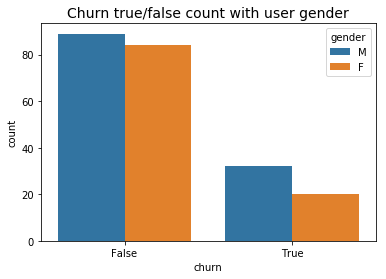

In [31]:
df_churn_pd = df_churn.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()
sns.barplot(x='churn', y='count', hue='gender', data=df_churn_pd)
plt.title("Churn true/false count with user gender", fontsize=14)
plt.show()

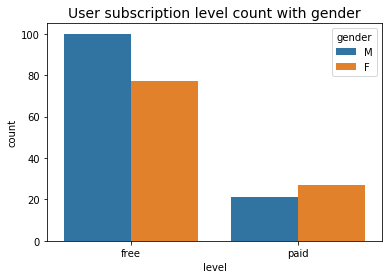

In [32]:
df_level_pd = df_churn.dropDuplicates(["userId", "gender"]).groupby(["gender", "level"]).count().toPandas()
sns.barplot(x='level', y='count', hue='gender', data=df_level_pd)
plt.title("User subscription level count with gender", fontsize=14)
plt.show()

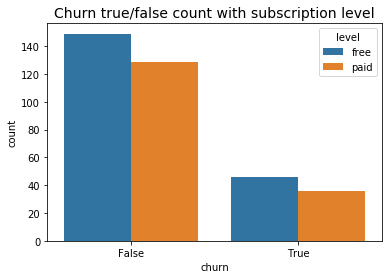

In [33]:
df_churn_level_pd = df_churn.dropDuplicates(["userId", "level"]).groupby(["churn", "level"]).count().sort("churn").toPandas()
sns.barplot(x='churn', y='count', hue='level', data=df_churn_level_pd)
plt.title("Churn true/false count with subscription level", fontsize=14)
plt.show()

In [ ]:
feat_df = df.withColumnRenamed('Cancellation Confirmation', 'churn')

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [34]:
def get_feature_df(df):
    """Takes in a cleaned event dataframe and returns a feature dataframe"""
    
    # Column names for the vector
    vector_cols = []
    
    # Get session counts
    session_counts = df.groupby('userId').agg(sf.countDistinct('sessionId').alias('session_count'))
    vector_cols.append('session_count')
    
    # Get pages and ignore events
    pages = df.select('page').distinct().sort('page')
    pages_list = [r.page for r in pages.collect()]
    drop_events = ['Cancel']
    
    # Get event counts
    feat_df = df.groupby('userId').pivot('page', pages_list).count()
    feat_df = feat_df.withColumnRenamed('Cancellation Confirmation', 'churn')
    feat_df = feat_df.drop(*drop_events).fillna(0)
    
    feat_df = feat_df.join(session_counts, on='userId')
    
    # Normalize by session counts
    ignore_cols = {'userId', 'session_count', 'churn'}
    remaining_cols = sorted(list(set(feat_df.columns) - ignore_cols))
    for column in remaining_cols:
        feat_df = feat_df.withColumn(column, sf.col(column) / feat_df.session_count)
    vector_cols.extend(remaining_cols)
    
    # Get account ages 
    max_timestamp = df.agg(sf.max('timestamp')).first()[0]
    account_ages = df.select('userId', 
                             sf.datediff(sf.lit(max_timestamp), df.registration_ts).alias('account_age')).distinct()
    
    vector_cols.append('account_age')
    feat_df = feat_df.join(account_ages, on='userId')
    
    # Get weekly song counts 
    week_counts = df.where(df.page=='NextSong') \
                .groupby('userId', sf.date_trunc('week', 'timestamp').cast('date').alias('week')).count() \
                .groupby('userId').pivot('week').sum().fillna(0)
    
    vector_cols.extend(week_counts.columns[1:])
    feat_df = feat_df.join(week_counts, on='userId')
    
    # Get genders for users
    genders = df.select('userId', sf.when(sf.col('gender')=='F', 0).otherwise(1).alias('genders')).distinct()
    
    vector_cols.append('genders')
    feat_df = feat_df.join(genders, on='userId')
    
    # Assemble the vector
    assembler = VectorAssembler(inputCols=vector_cols, outputCol='features')
    
    return assembler.transform(feat_df)

In [35]:
feature_df = get_feature_df(df)

In [36]:
feature_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- About: double (nullable = true)
 |-- Add Friend: double (nullable = true)
 |-- Add to Playlist: double (nullable = true)
 |-- churn: long (nullable = true)
 |-- Downgrade: double (nullable = true)
 |-- Error: double (nullable = true)
 |-- Help: double (nullable = true)
 |-- Home: double (nullable = true)
 |-- Logout: double (nullable = true)
 |-- NextSong: double (nullable = true)
 |-- Roll Advert: double (nullable = true)
 |-- Save Settings: double (nullable = true)
 |-- Settings: double (nullable = true)
 |-- Submit Downgrade: double (nullable = true)
 |-- Submit Upgrade: double (nullable = true)
 |-- Thumbs Down: double (nullable = true)
 |-- Thumbs Up: double (nullable = true)
 |-- Upgrade: double (nullable = true)
 |-- session_count: long (nullable = false)
 |-- account_age: integer (nullable = true)
 |-- 2018-10-01: long (nullable = true)
 |-- 2018-10-08: long (nullable = true)
 |-- 2018-10-15: long (nullable = true)
 |-- 2018-10-22

In [37]:
feature_df.persist()

DataFrame[userId: string, About: double, Add Friend: double, Add to Playlist: double, churn: bigint, Downgrade: double, Error: double, Help: double, Home: double, Logout: double, NextSong: double, Roll Advert: double, Save Settings: double, Settings: double, Submit Downgrade: double, Submit Upgrade: double, Thumbs Down: double, Thumbs Up: double, Upgrade: double, session_count: bigint, account_age: int, 2018-10-01: bigint, 2018-10-08: bigint, 2018-10-15: bigint, 2018-10-22: bigint, 2018-10-29: bigint, 2018-11-05: bigint, 2018-11-12: bigint, 2018-11-19: bigint, 2018-11-26: bigint, 2018-12-03: bigint, genders: int, features: vector]

In [38]:
feature_df.head(1)

[Row(userId='100010', About=0.14285714285714285, Add Friend=0.5714285714285714, Add to Playlist=1.0, churn=0, Downgrade=0.0, Error=0.0, Help=0.2857142857142857, Home=1.5714285714285714, Logout=0.7142857142857143, NextSong=39.285714285714285, Roll Advert=7.428571428571429, Save Settings=0.0, Settings=0.0, Submit Downgrade=0.0, Submit Upgrade=0.0, Thumbs Down=0.7142857142857143, Thumbs Up=2.4285714285714284, Upgrade=0.2857142857142857, session_count=7, account_age=67, 2018-10-01=0, 2018-10-08=31, 2018-10-15=89, 2018-10-22=0, 2018-10-29=0, 2018-11-05=131, 2018-11-12=0, 2018-11-19=24, 2018-11-26=0, 2018-12-03=0, genders=0, features=SparseVector(30, {0: 7.0, 1: 0.1429, 2: 0.5714, 3: 1.0, 6: 0.2857, 7: 1.5714, 8: 0.7143, 9: 39.2857, 10: 7.4286, 15: 0.7143, 16: 2.4286, 17: 0.2857, 18: 67.0, 20: 31.0, 21: 89.0, 24: 131.0, 26: 24.0}))]

In [39]:
feature_df.groupby('churn').count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



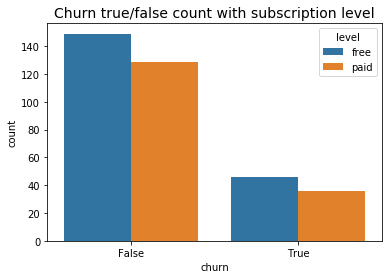

In [46]:
#df_churn_level_pd = df_churn_level_pd.dropDuplicates(["userId", "level"]).groupby(["churn", "level"]).count().sort("churn").toPandas()
sns.barplot(x='churn', y='count', hue='level', data=df_churn_level_pd)
plt.title("Churn true/false count with subscription level", fontsize=14)
plt.show()

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [51]:
train, test = feature_df.randomSplit([0.8, 0.2], seed=42)


In [52]:
def get_metrics(res):
    """Calcualtes the performance metrics of how well the model did Accuary, Precision, Recall, and F1"""
    total = res.count()
    
    tp = res.where((res.churn==1) & (res.prediction==1)).count()
    tn = res.where((res.churn==0) & (res.prediction==0)).count()    
    fp = res.where((res.churn==0) & (res.prediction==1)).count()
    fn = res.where((res.churn==1) & (res.prediction==0)).count()
        
    accuracy = (1.0*tp + tn) / total
    precision = 1.0*tp / (tp + fp)
    recall = 1.0*tp / (tp + fn)
    f1 = 2.0 * (precision * recall) / (precision + recall)
    
    print('Accuracy: ', round(accuracy, 2))
    print('Precision: ', round(precision, 2))
    print('Recall: ', round(recall, 2))
    print('F1-Score: ', round(f1, 2))

In [53]:
lr =  LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0,labelCol='churn')


In [54]:
lr_model = lr.fit(train)


In [55]:
results_lr = lr_model.transform(test)


In [56]:
results_lr

DataFrame[userId: string, About: double, Add Friend: double, Add to Playlist: double, churn: bigint, Downgrade: double, Error: double, Help: double, Home: double, Logout: double, NextSong: double, Roll Advert: double, Save Settings: double, Settings: double, Submit Downgrade: double, Submit Upgrade: double, Thumbs Down: double, Thumbs Up: double, Upgrade: double, session_count: bigint, account_age: int, 2018-10-01: bigint, 2018-10-08: bigint, 2018-10-15: bigint, 2018-10-22: bigint, 2018-10-29: bigint, 2018-11-05: bigint, 2018-11-12: bigint, 2018-11-19: bigint, 2018-11-26: bigint, 2018-12-03: bigint, genders: int, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [71]:
get_metrics(results_lr)

Accuracy:  0.65
Precision:  0.25
Recall:  0.25
F1-Score:  0.25


In [57]:
dt = DecisionTreeClassifier(labelCol='churn')
dt_model = dt.fit(train)
results_dt = dt_model.transform(test)
get_metrics(results_dt)

Accuracy:  0.74
Precision:  0.44
Recall:  0.5
F1-Score:  0.47


In [58]:
rf = RandomForestClassifier(labelCol='churn')

In [59]:
rf_model = rf.fit(train)
results_rf = rf_model.transform(test)
get_metrics(results_rf)

Accuracy:  0.88
Precision:  0.75
Recall:  0.75
F1-Score:  0.75


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [60]:
rf_paramGrid = ParamGridBuilder() \
                .addGrid(rf.maxDepth, [5, 9]) \
                .addGrid(rf.minInstancesPerNode, [1, 3]) \
                .addGrid(rf.numTrees, [20, 45]) \
                .build()

In [61]:
rf_crossval = CrossValidator(estimator = rf,
                             estimatorParamMaps=rf_paramGrid,
                             evaluator = BinaryClassificationEvaluator(labelCol='churn'),
                             numFolds=3)

In [62]:
rf_cross_model = rf_crossval.fit(train)


In [63]:
results_rf_cross = rf_cross_model.transform(test)


In [64]:
rf_cross_model.avgMetrics


[0.9138637323593719,
 0.9191583454511849,
 0.9032803090139381,
 0.9205682989151469,
 0.9124859805608734,
 0.9295242849595664,
 0.9012803186036048,
 0.9186315676141257]

In [65]:
get_metrics(results_rf_cross)


Accuracy:  0.85
Precision:  0.71
Recall:  0.62
F1-Score:  0.67


In [66]:
print('Num Trees', rf_cross_model.bestModel.getNumTrees)
print('Max Depth', rf_cross_model.bestModel._java_obj.getMaxDepth())
print('Min Samples Node', rf_cross_model.bestModel._java_obj.getMinInstancesPerNode())

Num Trees 45
Max Depth 9
Min Samples Node 1


In [67]:
rf_importances = list(rf_cross_model.bestModel.featureImportances)


In [68]:
cols = feature_df.columns[1:4]+feature_df.columns[5:-1]


In [69]:
from pprint import pprint


In [70]:
pprint(sorted(zip(cols, rf_importances), key=lambda x: x[1], reverse=True))


[('2018-11-19', 0.12201302462624609),
 ('2018-11-26', 0.10893182268612639),
 ('2018-11-12', 0.073667593553108202),
 ('2018-10-01', 0.061441798106196543),
 ('2018-10-08', 0.060847814185098346),
 ('About', 0.058441220405621705),
 ('Upgrade', 0.047298110461652325),
 ('2018-11-05', 0.045917428197947682),
 ('Save Settings', 0.035107382430819414),
 ('Thumbs Up', 0.03335742798028607),
 ('NextSong', 0.033161168584564263),
 ('2018-10-29', 0.029280460525307205),
 ('Downgrade', 0.02636911940962372),
 ('Submit Downgrade', 0.025412675300250875),
 ('Add to Playlist', 0.024878415080827589),
 ('Add Friend', 0.023663453738084792),
 ('Logout', 0.022893727451975245),
 ('account_age', 0.022775632449501537),
 ('Roll Advert', 0.021616718551687477),
 ('Home', 0.021389046547175595),
 ('session_count', 0.021199782242919362),
 ('2018-10-22', 0.017371287246595576),
 ('Thumbs Down', 0.014517517231116687),
 ('Error', 0.012838783037837935),
 ('2018-10-15', 0.012575027093659066),
 ('Settings', 0.0073345140150518741)